In [1]:
# Make a squence estimator that gets observation and time as input, and outputs predicted attention for time

In [2]:
# 1. Make dataset
# 2. Make model
# 3. Train model
# 4. Evaluate model

In [3]:
import sys
sys.path.append('../')

In [4]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torch.utils.data import DataLoader
from diffusion_policy.dataset.robomimic_replay_image_dataset import RobomimicReplayImageDataset
from diffusion_policy.dataset.robomimic_replay_lowdim_dataset import RobomimicReplayLowdimDataset

In [5]:
lowdim_dataset_path = "../data/robomimic/datasets/lift/ph/low_dim_abs_with_sine_wave.hdf5"
lowdim_dataset = RobomimicReplayLowdimDataset(lowdim_dataset_path, horizon=16, pad_before=1, pad_after=7, obs_keys=['object', 'robot0_eef_pos', 'robot0_eef_quat', 'robot0_gripper_qpos', 'spatial_attention'], abs_action=True, rotation_rep='rotation_6d', use_legacy_normalizer=False, seed=42, val_ratio=0.02, max_train_episodes=None)
val_dataset = lowdim_dataset.get_validation_dataset()

train_dataloader = DataLoader(lowdim_dataset, batch_size=256, shuffle=False)
val_dataloader = DataLoader(val_dataset, batch_size=256, shuffle=False)

display_dataloader = DataLoader(
    RobomimicReplayLowdimDataset(lowdim_dataset_path, horizon=16, pad_before=1, pad_after=7, obs_keys=['object', 'robot0_eef_pos', 'robot0_eef_quat', 'robot0_gripper_qpos', 'spatial_attention'], abs_action=True, rotation_rep='rotation_6d', use_legacy_normalizer=False, seed=42, val_ratio=0.0, max_train_episodes=None),
    batch_size=1,
    shuffle=False
)

normalizer = lowdim_dataset.get_normalizer()


Loading hdf5 to ReplayBuffer: 100%|██████████| 200/200 [00:00<00:00, 1295.63it/s]


In [6]:
# class AttentionEstimator(nn.Module):
#     def __init__(self, input_dim=19, output_dim=1, hidden_dim=256):
#         super().__init__()
#         t_embedding_dim = 8
#         self.input_dim = input_dim + t_embedding_dim
#         self.output_dim = output_dim
#         self.hidden_dim = hidden_dim
#         # Define the network architecture
#         self.fc1 = nn.Linear(input_dim+t_embedding_dim, hidden_dim)
#         self.fc2 = nn.Linear(hidden_dim, hidden_dim)
#         self.fc3 = nn.Linear(hidden_dim, hidden_dim)
#         self.fc4 = nn.Linear(hidden_dim, hidden_dim)
#         self.fc5 = nn.Linear(hidden_dim, output_dim)
        
#         # Initialize weights
#         self._init_weights()
    
#     def _init_weights(self):
#         for m in self.modules():
#             if isinstance(m, nn.Linear):
#                 nn.init.kaiming_normal_(m.weight, mode='fan_in', nonlinearity='relu')
#                 nn.init.zeros_(m.bias)
    
#     def forward(self, x, t):
#         # Input shape: (batch_size, input_dim)
#         # Time embedding
#         t = t.unsqueeze(-1)
#         t_embedding = torch.cat([
#             torch.sin(t * 0.1),
#             torch.cos(t * 0.1),
#             torch.sin(t * 1.0), 
#             torch.cos(t * 1.0),
#             torch.sin(t * 10.0),
#             torch.cos(t * 10.0),
#             torch.sin(t * 100.0),
#             torch.cos(t * 100.0)
#         ], dim=-1).squeeze()
        
#         # Combine input with time embedding
#         x = torch.cat([x, t_embedding], dim=-1)
        
#         x = F.relu(self.fc1(x))
#         x = F.relu(self.fc2(x))
#         x = F.relu(self.fc3(x))
#         x = F.relu(self.fc4(x))
#         x = self.fc5(x)
#         return x
    
class AttentionEstimator(nn.Module):
    def __init__(self, input_dim=19, output_dim=16, hidden_dim=256):
        super().__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.hidden_dim = hidden_dim
        # Define the network architecture
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, hidden_dim)
        self.fc4 = nn.Linear(hidden_dim, hidden_dim)
        self.fc5 = nn.Linear(hidden_dim, output_dim)
        
        # Initialize weights
        self._init_weights()
    
    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight, mode='fan_in', nonlinearity='relu')
                nn.init.zeros_(m.bias)
    
    def forward(self, x):
        # Input shape: (batch_size, input_dim)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        x = self.fc5(x)
        return x

In [7]:
train_data_sample = next(iter(train_dataloader))

Doutput = train_data_sample['obs'][0, :, -1].shape[0]
Dinput = train_data_sample['obs'][0, :, :-1].shape[-1] * 2



In [12]:
# attention_estimator = AttentionEstimator(Dinput, 1)

# criterion = nn.MSELoss()
# optimizer = optim.AdamW(attention_estimator.parameters(), lr=0.001)

# val_losses = []

# for epoch in range(50):
#     for batch in train_dataloader:
#         optimizer.zero_grad()
        
#         B, T, D = batch['obs'].shape
#         nobs = normalizer['obs'].unnormalize(batch['obs'])
        
#         # Reshape input to B*T, D+1 where last dim is time index
#         obs = torch.repeat_interleave(nobs[:, :2, :-1].reshape(B, -1), T, dim=0)  # B*T, 2D
#         time_idx = torch.arange(T, device=obs.device).repeat(B).unsqueeze(-1)  # B*T, 1
#         # obs = torch.cat([obs, time_idx.unsqueeze(-1)], dim=-1)  # B*T, D
        
#         # Reshape target to B*T, 1
#         attention = nobs[:, :, -1].reshape(-1, 1)  # B*T, 1
        
#         output = attention_estimator(obs, time_idx)
#         loss = criterion(output, attention)
#         loss.backward()
#         optimizer.step()
#         print(loss.item())
        
#     for batch in val_dataloader:
#         B, T, D = batch['obs'].shape
#         nobs = normalizer['obs'].unnormalize(batch['obs'])
        
#         # Reshape input to B*T, D+1 where last dim is time index
#         obs = torch.repeat_interleave(nobs[:, :2, :-1].reshape(B, -1), T, dim=0)  # B*T, 2D
#         time_idx = torch.arange(T, device=obs.device).repeat(B).unsqueeze(-1)  # B*T, 1
#         # obs = torch.cat([obs, time_idx.unsqueeze(-1)], dim=-1)  # B*T, D
        
#         # Reshape target to B*T, 1
#         attention = nobs[:, :, -1].reshape(-1, 1)  # B*T, 1
        
#         output = attention_estimator(obs, time_idx)
#         val_loss = criterion(output, attention)
#         val_losses.append(val_loss.item())
        
#     print(f"Epoch {epoch} train loss: {loss}, val loss: {val_losses[-1]}")
    
# val_losses = np.array(val_losses)
# print(val_loss.min())

attention_estimator = AttentionEstimator(Dinput, Doutput)

criterion = nn.MSELoss()
optimizer = optim.AdamW(attention_estimator.parameters(), lr=0.001)

val_losses = []

for epoch in range(50):
    for batch in train_dataloader:
        optimizer.zero_grad()
        
        B, T, D = batch['obs'].shape
        nobs = normalizer['obs'].unnormalize(batch['obs'])
        
        obs = nobs[:, :2, :-1].reshape(B, -1)
        attention = nobs[:, :, -1]
        
        # # Reshape input to B*T, D+1 where last dim is time index
        # obs = torch.repeat_interleave(nobs[:, :2, :-1].reshape(B, -1), T, dim=0)  # B*T, 2D
        # time_idx = torch.arange(T, device=obs.device).repeat(B).unsqueeze(-1)  # B*T, 1
        # # obs = torch.cat([obs, time_idx.unsqueeze(-1)], dim=-1)  # B*T, D
        
        # # Reshape target to B*T, 1
        # attention = nobs[:, :, -1].reshape(-1, 1)  # B*T, 1
        
        output = attention_estimator(obs)
        loss = criterion(output, attention)
        loss.backward()
        optimizer.step()
        print(loss.item())
        
    for batch in val_dataloader:
        optimizer.zero_grad()
        
        B, T, D = batch['obs'].shape
        nobs = normalizer['obs'].unnormalize(batch['obs'])
        
        obs = nobs[:, :2, :-1].reshape(B, -1)
        attention = nobs[:, :, -1]
        
        output = attention_estimator(obs)
        val_loss = criterion(output, attention)
        val_losses.append(val_loss.item())
        
    print(f"Epoch {epoch} train loss: {loss}, val loss: {val_losses[-1]}")
    
val_losses = np.array(val_losses)
print(val_loss.min())



1.1567730903625488
0.36465224623680115
0.14447760581970215
0.17161902785301208
0.18809431791305542
0.15808561444282532
0.10799244046211243
0.07327806949615479
0.0611211322247982
0.06335584074258804
0.07157712429761887
0.07539542019367218
0.0678180381655693
0.060634300112724304
0.045620713382959366
0.041638851165771484
0.04354478418827057
0.035821110010147095
0.04296157509088516
0.041265878826379776
0.037809934467077255
0.03724417835474014
0.030226420611143112
0.02517133578658104
0.025644008070230484
0.023493144661188126
0.02404269017279148
0.034703828394412994
0.026989899575710297
0.024028806015849113
0.01716865971684456
0.019497008994221687
Epoch 0 train loss: 0.019497008994221687, val loss: 0.017394643276929855
0.026406198740005493
0.02396572381258011
0.01519162766635418
0.015011955052614212
0.013474885374307632
0.019184483215212822
0.017397677525877953
0.013986242935061455
0.013981920666992664
0.01363581232726574
0.012863699346780777
0.013922341167926788
0.013352837413549423
0.01726

6163
0.005357782822102308
torch.Size([1, 16]) torch.Size([1, 16])


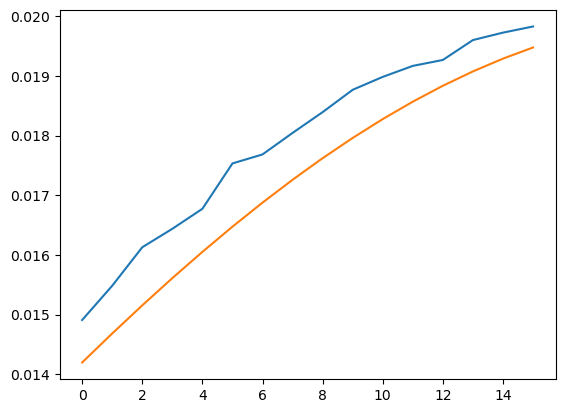

In [40]:
# iterator = iter(display_dataloader)
# for _ in range(1223):
#     batch = next(iterator)

# with torch.no_grad():
#     B, T, D = batch['obs'].shape
#     nobs = normalizer['obs'].unnormalize(batch['obs'])
    
#     # Reshape input to B*T, D+1 where last dim is time index
#     obs = torch.repeat_interleave(nobs[:, :2, :-1].reshape(B, -1), T, dim=0)  # B*T, 2D
#     time_idx = torch.arange(T, device=obs.device).repeat(B).unsqueeze(-1)  # B*T, 1
#     # obs = torch.cat([obs, time_idx.unsqueeze(-1)], dim=-1)  # B*T, D
    
#     # Reshape target to B*T, 1
#     attention = nobs[:, :, -1].reshape(-1, 1)  # B*T, 1
    
#     output = attention_estimator(obs, time_idx)
    
#     print(nn.MSELoss()(output, attention).item())
#     print(output.shape, attention.shape)
    
#     attention_pred = normalizer['obs'].normalize(np.concatenate([nobs[:, :, :-1], output.unsqueeze(0)], axis=-1))[:, :, -1]
    
# from matplotlib import pyplot as plt
# plt.plot(attention_pred[0])
# plt.plot(batch['obs'][0, :, -1])

iterator = iter(display_dataloader)
idx = np.random.randint(0, len(display_dataloader))
print(idx)
for _ in range(idx):
    batch = next(iterator)

with torch.no_grad():
    B, T, D = batch['obs'].shape
    nobs = normalizer['obs'].unnormalize(batch['obs'])
    
    obs = nobs[:, :2, :-1].reshape(B, -1)
    attention = nobs[:, :, -1]
    
    # # Reshape input to B*T, D+1 where last dim is time index
    # obs = torch.repeat_interleave(nobs[:, :2, :-1].reshape(B, -1), T, dim=0)  # B*T, 2D
    # time_idx = torch.arange(T, device=obs.device).repeat(B).unsqueeze(-1)  # B*T, 1
    # # obs = torch.cat([obs, time_idx.unsqueeze(-1)], dim=-1)  # B*T, D
    
    # # Reshape target to B*T, 1
    # attention = nobs[:, :, -1].reshape(-1, 1)  # B*T, 1
    
    output = attention_estimator(obs)


    print(nn.MSELoss()(output, attention).item())
    print(output.shape, attention.shape)
    
    attention_pred = normalizer['obs'].normalize(np.concatenate([nobs[:, :, :-1], output.unsqueeze(-1)], axis=-1))[:, :, -1]
    
from matplotlib import pyplot as plt
plt.plot(attention_pred[0])
plt.plot(batch['obs'][0, :, -1])

In [10]:
attention_pred.shape

torch.Size([1, 16])